In [135]:
%pip install numpy dynesty emcee astropy scipy corner

Note: you may need to restart the kernel to use updated packages.


500


<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
/var/folders/x5/_d4kcw01559cdbm8yn5mc8zm0000gn/T/ipykernel_14572/2636976705.py:8: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu$")


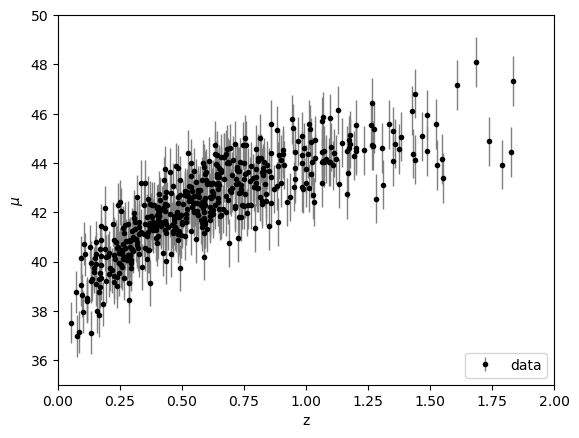

In [132]:
from pylab import plt
import numpy as np

z_sample,mu_sample,dmu=np.loadtxt('datasets/supernovae.txt').T

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

print(len(z_sample))

In [139]:
# Loading libraries
import astropy.units as u
from astropy.cosmology import LambdaCDM
import scipy.optimize
from scipy.integrate import quad
from scipy.stats import gaussian_kde, norm, uniform

import emcee
import corner
import numpy as np
import pylab as plt
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

In [6]:
# Defining constants
c = 299792.458 # km/s (speed of light)
Mpc_to_pc = 1e6 # 1 Mpc = 10^6 pc

In [18]:
#Utility functions
def plot_chain(samples, labels):
  ndim = len(labels)
  plt.figure(figsize=(14, 10))
  for i, label in enumerate(labels):
    plt.subplot(ndim, 1, i+1)
    plt.plot(samples[:, :, i], alpha=0.3)
    plt.ylabel(label)
    plt.tight_layout()

def plot_chain_flattened(samples, labels):
  ndim = len(labels)
  plt.figure(figsize=(14, 10))
  for i, label in enumerate(labels):
    plt.subplot(ndim, 1, i+1)
    plt.plot(samples[:, i], alpha=0.3)
    plt.ylabel(label)
    plt.tight_layout()

def calculate_credible_region(samples, parameter_name):
  # Calculate the 5th, 50th, and 95th percentiles
  p5, p50, p95 = np.percentile(samples, [5, 50, 95])

  # Format and print the results
  print(f"{parameter_name} = {p50:.3f}_{{-{p50-p5:.3f}}}^{{+{p95-p50:.3f}}}")

  return p50, p5, p95

##STEP 1
Numerical Integration


In [8]:
def integrand(z_prime, Omega_m, Omega_Lambda):
    return 1.0 / np.sqrt(Omega_m * (1 + z_prime)**3 + Omega_Lambda)

In [9]:
# Function to calculate the distance modulus mu
def distance_modulus(z, H0, Omega_m, Omega_Lambda):
    # Ensure H0 is not zero to avoid division by zero
    if H0 <= 0:
        return np.inf

    integral, _ = quad(integrand, 0, z, args=(Omega_m, Omega_Lambda))

    # Check for cases where the integral might be problematic (e.g., negative or non-finite)
    if not np.isfinite(integral) or integral < 0:
        return np.inf

    # Calculate luminosity distance in Mpc
    dL_Mpc = (c / H0) * (1 + z) * integral

    # Convert Mpc to parsec
    dL_pc = dL_Mpc * Mpc_to_pc

    # Calculate distance modulus
    mu = 5 * np.log10(dL_pc / 10.0)
    return mu

<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\m'
/var/folders/x5/_d4kcw01559cdbm8yn5mc8zm0000gn/T/ipykernel_14572/3036475221.py:19: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu$")


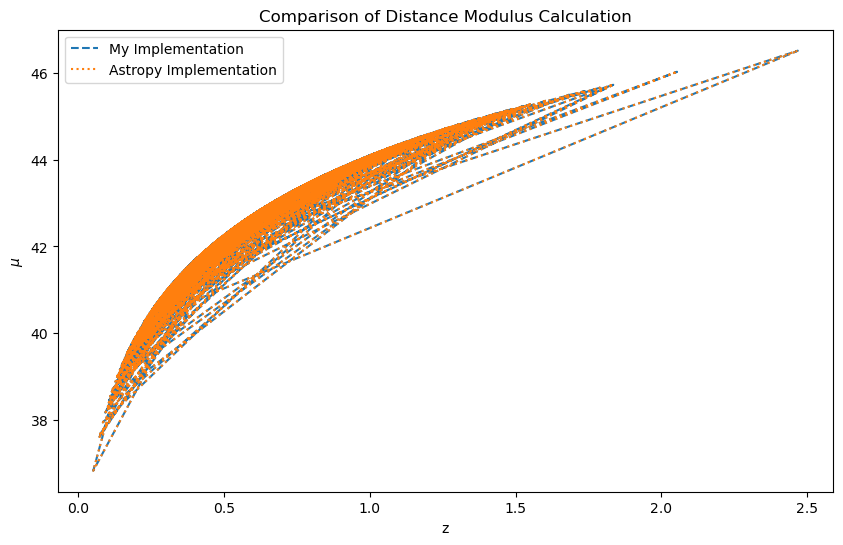

Sample Z values: [0.29907871 0.64057897 0.48439381 0.83200371 0.82408678]
Our Implementation mu values: [np.float64(40.94775710729471), np.float64(42.911766027864395), np.float64(42.1786634252568), np.float64(43.607379784281235), np.float64(43.581820387287245)]
Astropy mu values: [40.94775711 42.91176603 42.17866343 43.60737978 43.58182039]


In [48]:
# Check the implementation with astropy
# Set some fiducial values for comparison
H0_fid = 70.0  # km/s/Mpc
Omega_m_fid = 0.3
Omega_Lambda_fid = 0.7

# Calculate mu using our implementation
mu_our_implementation = [distance_modulus(zi, H0_fid, Omega_m_fid, Omega_Lambda_fid) for zi in z_sample]

# Calculate mu using astropy
cosmo = LambdaCDM(H0=H0_fid * u.km / u.s / u.Mpc, Om0=Omega_m_fid, Ode0=Omega_Lambda_fid, Tcmb0=0*u.K, Neff=3.04)
mu_astropy = cosmo.distmod(z_sample).value

# Plot to compare
plt.figure(figsize=(10, 6))
plt.plot(z_sample, mu_our_implementation, label='My Implementation', linestyle='--')
plt.plot(z_sample, mu_astropy, label='Astropy Implementation', linestyle=':')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title("Comparison of Distance Modulus Calculation")
plt.legend()
plt.show()

# Print a few values for numerical comparison
print("Sample Z values:", z_sample[:5])
print("Our Implementation mu values:", mu_our_implementation[:5])
print("Astropy mu values:", mu_astropy[:5])

##STEP 2
Having dark energy density equal to zero and a flat geometry of the universe, the model simplifies to a one parameter model with H0 as a parameter. The integral, after computation becomes: [-2(1+z')^(-1/2)] computed between 0 and z, simplifying we get:
 -2(1+z)^(-1)

In [71]:
# Define the log-likelihood function
def log_likelihood_h0_only(theta, z, mu_obs, dmu_obs):
    H0 = theta[0] # H0 is the only parameter we're fitting
    Omega_m = 1.0
    Omega_Lambda = 0.0

    # Calculate model mu for all z_sample points
    mu_model = np.array([distance_modulus(zi, H0, Omega_m, Omega_Lambda) for zi in z])

    # Handle cases where mu_model might be inf or NaN (e.g., from invalid H0 values)
    if not np.all(np.isfinite(mu_model)):
        return -np.inf

    # Calculate chi-squared
    chi2 = np.sum(((mu_obs - mu_model) / dmu_obs)**2)

    # Return negative half of chi-squared for log-likelihood (ignoring constant terms)
    return -0.5 * chi2

# Define the log-prior function
def log_prior_h0_only(theta):
    H0 = theta[0]
    # We set a uniform prior for H0, say between 50 and 100 km/s/Mpc
    # This range is chosen to be broad enough to cover plausible values.
    if 50.0 < H0 < 100.0:
        return 0.0  # Log of 1 (uniform probability)
    return -np.inf # Log of 0 (zero probability outside bounds)

# Define the log-posterior function
def log_posterior_h0_only(theta, z, mu_obs, dmu_obs):
    # First, check the prior
    lp = log_prior_h0_only(theta)
    if not np.isfinite(lp):
        return -np.inf # If prior is -inf, posterior is -inf

    # If prior is finite, add the log-likelihood
    return lp + log_likelihood_h0_only(theta, z, mu_obs, dmu_obs)

**MCMC**

In [ ]:
nwalkers = 8
nsteps = 10000
ndim = 1
pos = uniform.rvs(loc=50, scale=15, size=(nwalkers, ndim))

sampler_h0_only = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_h0_only, args=(z_sample, mu_sample, dmu))
sampler_h0_only.run_mcmc(pos, nsteps, progress=True)

100%|██████████| 10000/10000 [27:52<00:00,  5.98it/s]


State([[58.56567398]
 [59.21934097]
 [56.4557302 ]
 [57.96509609]
 [56.98731596]
 [58.3421202 ]
 [58.91863653]
 [58.02841241]], log_prob=[-237.0085733  -237.33237672 -238.24683314 -236.99837811 -237.59346025
 -236.97214649 -237.14359268 -236.98621157], blobs=None, random_state=('MT19937', array([2133016164, 3114345767, 1828568003, 3216770431, 1812912695,
       2520615122,  589427677,  484230246,  398755240,  806995321,
       1836042999, 2694317894, 2076690488,  907965227, 2156809949,
       2580689010, 2288776408,  151975307, 2684718392, 1233469726,
       2570956526, 3727177000, 1804144792,  964236844, 2116350294,
       2184584218, 3574147762, 4200277319, 3809240071,  188890195,
       4278323976, 1530401260, 2742407233, 1619025185, 1232951208,
       2938656801,  820144357, 1779629180, 3538217610,  151506903,
       1700996139, 1417961802,  985552319, 1945945320,  752180749,
       3094720756, 4012212665, 1567156776, 2924392584, 4002208594,
       2923295225, 3512473561, 201864953

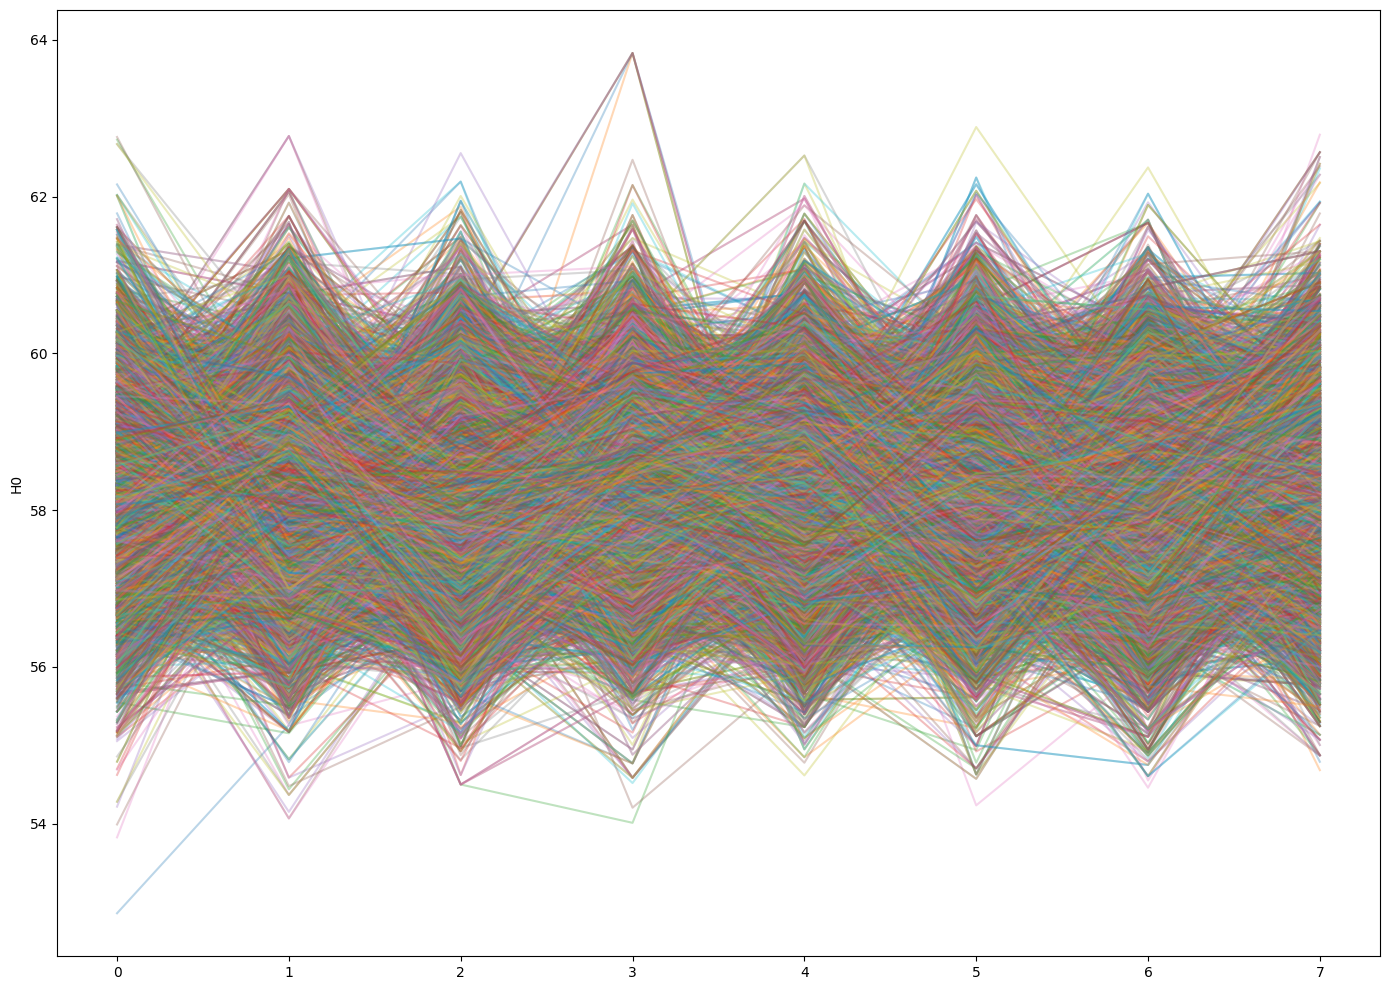

In [ ]:
labels = ['H0']
plot_chain(sampler_h0_only.chain, labels)

In [ ]:
tau = sampler_h0_only.get_autocorr_time()
print(f"Autocorrelation times: {tau}")
burnin = 1000
thin = int(np.max(tau) / 2)

print(f"Burn-in: {burnin} steps")
print(f"Thin: {thin} steps")

Autocorrelation times: [26.95241235]
Burn-in: 1000 steps
Thin: 13 steps


In [ ]:
samples = sampler_h0_only.get_chain(discard=burnin, thin=thin, flat=True)
print(f"Number of samples after burn-in and thinning: {len(samples)}")

Number of samples after burn-in and thinning: 5536


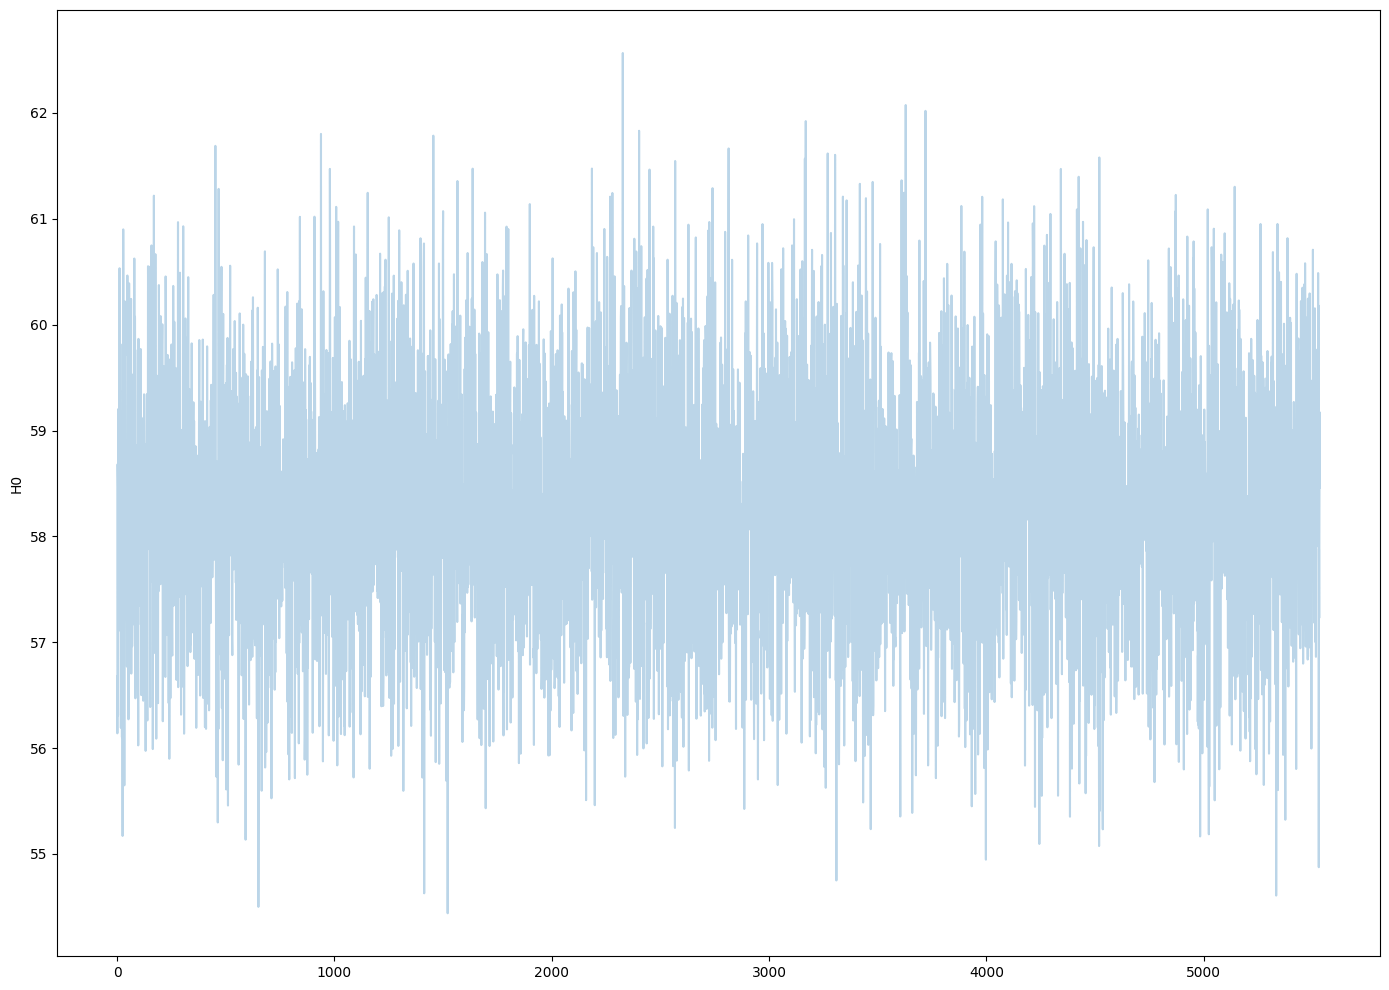

In [ ]:
plot_chain_flattened(samples, labels)

In [ ]:
calculate_credible_region(samples, 'H0')

H0 = 58.264_{-1.863}^{+1.926}


(np.float64(58.264469124500756),
 np.float64(56.40190683999448),
 np.float64(60.190801378155705))

**Nested Sampling**

In [120]:
# Log-likelihood function for dynesty
def log_likelihood_h0_only_dynesty(theta, z, mu_obs, dmu_obs):
    H0 = theta[0]
    Omega_m = 1.0
    Omega_Lambda = 0.0

    mu_model = np.array([distance_modulus(zi, H0, Omega_m, Omega_Lambda) for zi in z])

    if not np.all(np.isfinite(mu_model)):
        return -np.inf

    chi2 = np.sum(((mu_obs - mu_model) / dmu_obs)**2)
    return -0.5 * chi2

# Prior transform function for H0 only
def prior_transform_h0_only(u):
    # Map u from [0, 1] to our H0 prior range [50, 70]
    H0 = u[0] * (70.0 - 50.0) + 50.0
    return [H0]

In [121]:
# Set up the nested sampler
ndim = 1
sampler_nested_h0_only = dynesty.NestedSampler(log_likelihood_h0_only_dynesty, prior_transform_h0_only, ndim,
                                               logl_args=(z_sample, mu_sample, dmu),
                                               bound='multi', sample='unif')

# Run the nested sampling
sampler_nested_h0_only.run_nested()

# Get the results
results_h0_only = sampler_nested_h0_only.results

1403it [00:55, 25.29it/s, +500 | bound: 0 | nc: 1 | ncall: 10074 | eff(%): 19.877 | loglstar:   -inf < -236.968 <    inf | logz: -238.865 +/-  0.025 | dlogz:  0.001 >  0.509]


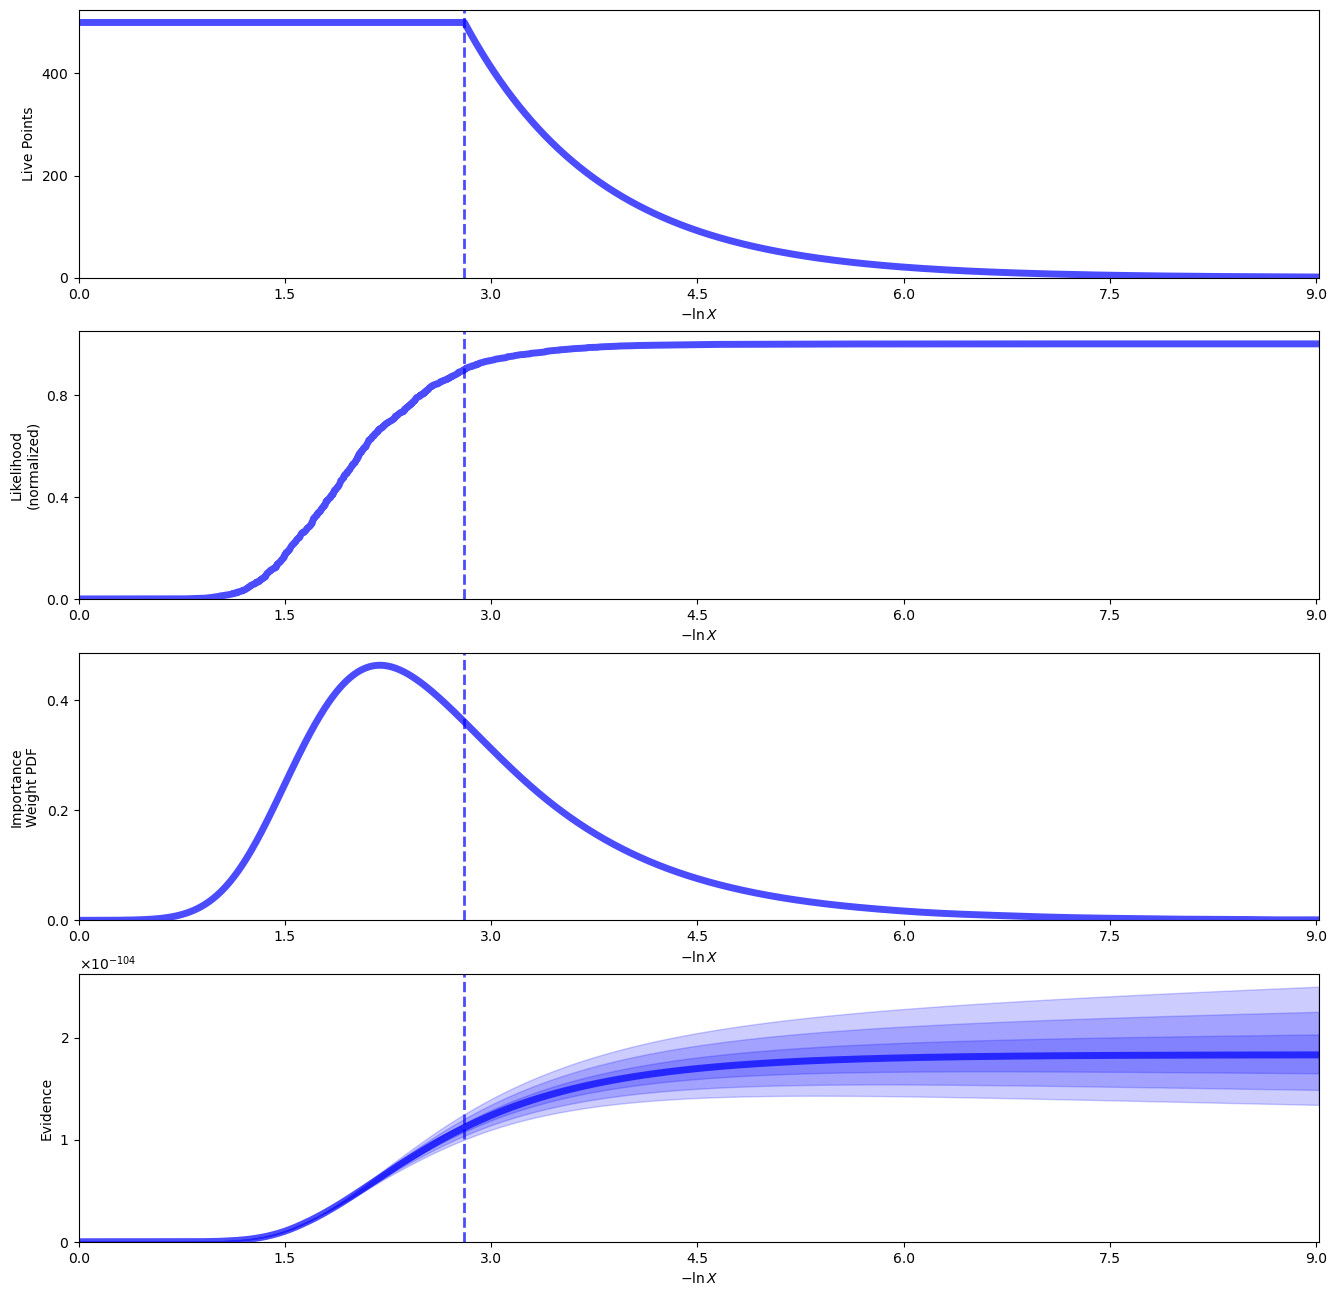

In [122]:
rfig, raxes = dyplot.runplot(results_h0_only)

In [123]:
samples = results_h0_only.samples
log_weights = results_h0_only.logwt
log_evidence_h0_only = results_h0_only.logz[-1]
weights = np.exp(log_weights - log_evidence_h0_only)

posterior_samples = dyfunc.resample_equal(samples, weights)

In [124]:
print(f'H0 median: {np.median(posterior_samples[:, 0])}')

H0 median: 58.22912854933344


In [125]:
print(f'Log Evidence (H0 only): {log_evidence_h0_only}')

Log Evidence (H0 only): -238.86459754593878


##STEP 3
I consider a two parameter model, estimating H_0 and Ω_m, still under the flat universe assumption

**MCMC**

In [10]:
# Log-likelihood function for the 2-parameter model
def log_likelihood_h0_omegam(theta, z, mu_obs, dmu_obs):
    H0, Omega_m = theta
    Omega_Lambda = 1.0 - Omega_m

    # Physical constraints for a flat universe model
    if not (0.0 <= Omega_m <= 1.0):
        return -np.inf

    mu_model = np.array([distance_modulus(zi, H0, Omega_m, Omega_Lambda) for zi in z])

    if not np.all(np.isfinite(mu_model)):
        return -np.inf

    chi2 = np.sum(((mu_obs - mu_model) / dmu_obs)**2)
    return -0.5 * chi2

# Log-prior function for the 2-parameter model
def log_prior_h0_omegam(theta):
    H0, Omega_m = theta
    # Uniform priors
    if 50.0 < H0 < 100.0 and 0.0 <= Omega_m <= 1.0:
        return 0.0
    return -np.inf

# Log-posterior function
def log_posterior_h0_omegam(theta, z, mu_obs, dmu_obs):
    lp = log_prior_h0_omegam(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_h0_omegam(theta, z, mu_obs, dmu_obs)


In [11]:
initial_pos_h0_omegam = [70.0, 0.3]
nwalkers = 8
nsteps = 10000
ndim = 2
pos_h0_omegam = initial_pos_h0_omegam + 1e-3 * np.random.randn(nwalkers, ndim)

sampler_h0_omegam = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_h0_omegam, args=(z_sample, mu_sample, dmu))
sampler_h0_omegam.run_mcmc(pos_h0_omegam, nsteps, progress=True)

100%|██████████| 10000/10000 [08:40<00:00, 19.21it/s]


State([[67.44726488  0.44764659]
 [65.01104119  0.59985703]
 [69.95193417  0.32648237]
 [60.35085566  0.65394411]
 [62.39019899  0.72671197]
 [65.33486213  0.40150325]
 [61.3231792   0.8140615 ]
 [66.18942361  0.38036062]], log_prob=[-234.60486209 -235.03553553 -235.10116519 -237.56013222 -235.34435821
 -236.74025082 -235.92060989 -236.26112523], blobs=None, random_state=('MT19937', array([ 742027777,  386118189, 1468693372, 3602367093,  982092096,
       2487506269, 2209674865, 3378593103, 4139587670, 1065765604,
       3428141361, 4167782091, 2847767774, 2179186116,  987418888,
       1537824385, 1076128487, 1021505511, 3881775304, 3492677554,
        188555611,  356560744, 3994714808,  740472867, 1216642903,
        768558672, 3967167931, 1086363358, 3170471546, 3633225322,
       3485855721,  225529266, 2294789093,  200638928, 2005625090,
       1061256078, 3766619818, 3558283151, 4261514756,  947919849,
       3100052762,  911656385,  766635340,  519820744, 2920588800,
        865

<>:1: SyntaxWarning: invalid escape sequence '\O'
<>:1: SyntaxWarning: invalid escape sequence '\O'
/var/folders/x5/_d4kcw01559cdbm8yn5mc8zm0000gn/T/ipykernel_14572/3652857692.py:1: SyntaxWarning: invalid escape sequence '\O'
  labels = ['H0', '$\Omega_m$']


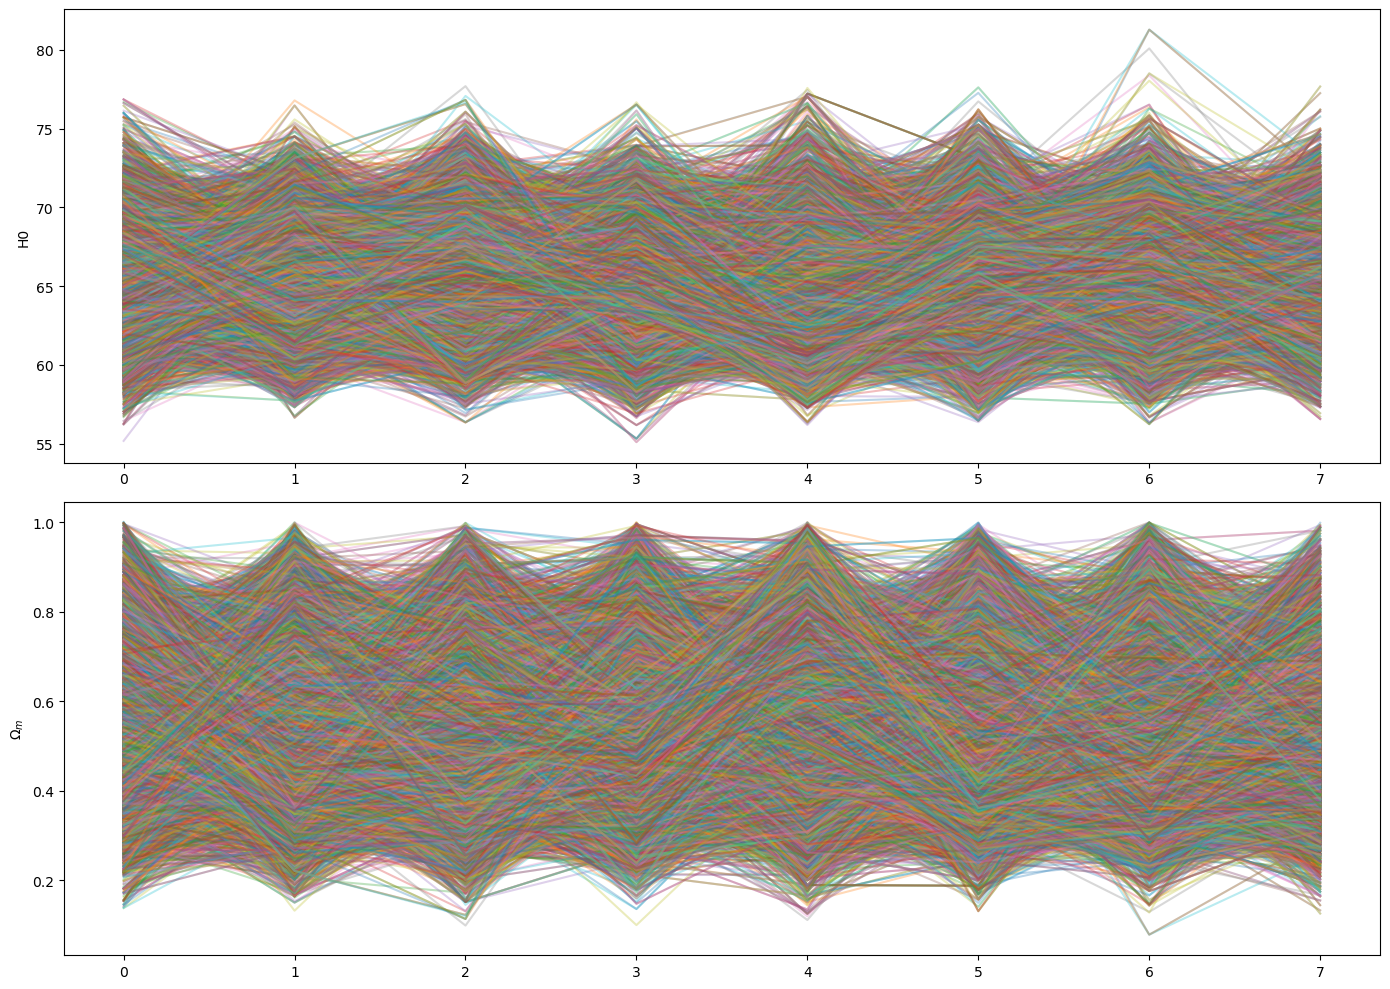

In [12]:
labels = ['H0', '$\Omega_m$']
plot_chain(sampler_h0_omegam.chain, labels)

In [14]:
tau = sampler_h0_omegam.get_autocorr_time()
print(f"Autocorrelation times: {tau}")
burnin = 1000
thin = int(np.max(tau) / 2)

print(f"Burn-in: {burnin} steps")
print(f"Thin: {thin} steps")

Autocorrelation times: [36.69567904 37.10652208]
Burn-in: 1000 steps
Thin: 18 steps


Number of samples after burn-in and thinning: 4000


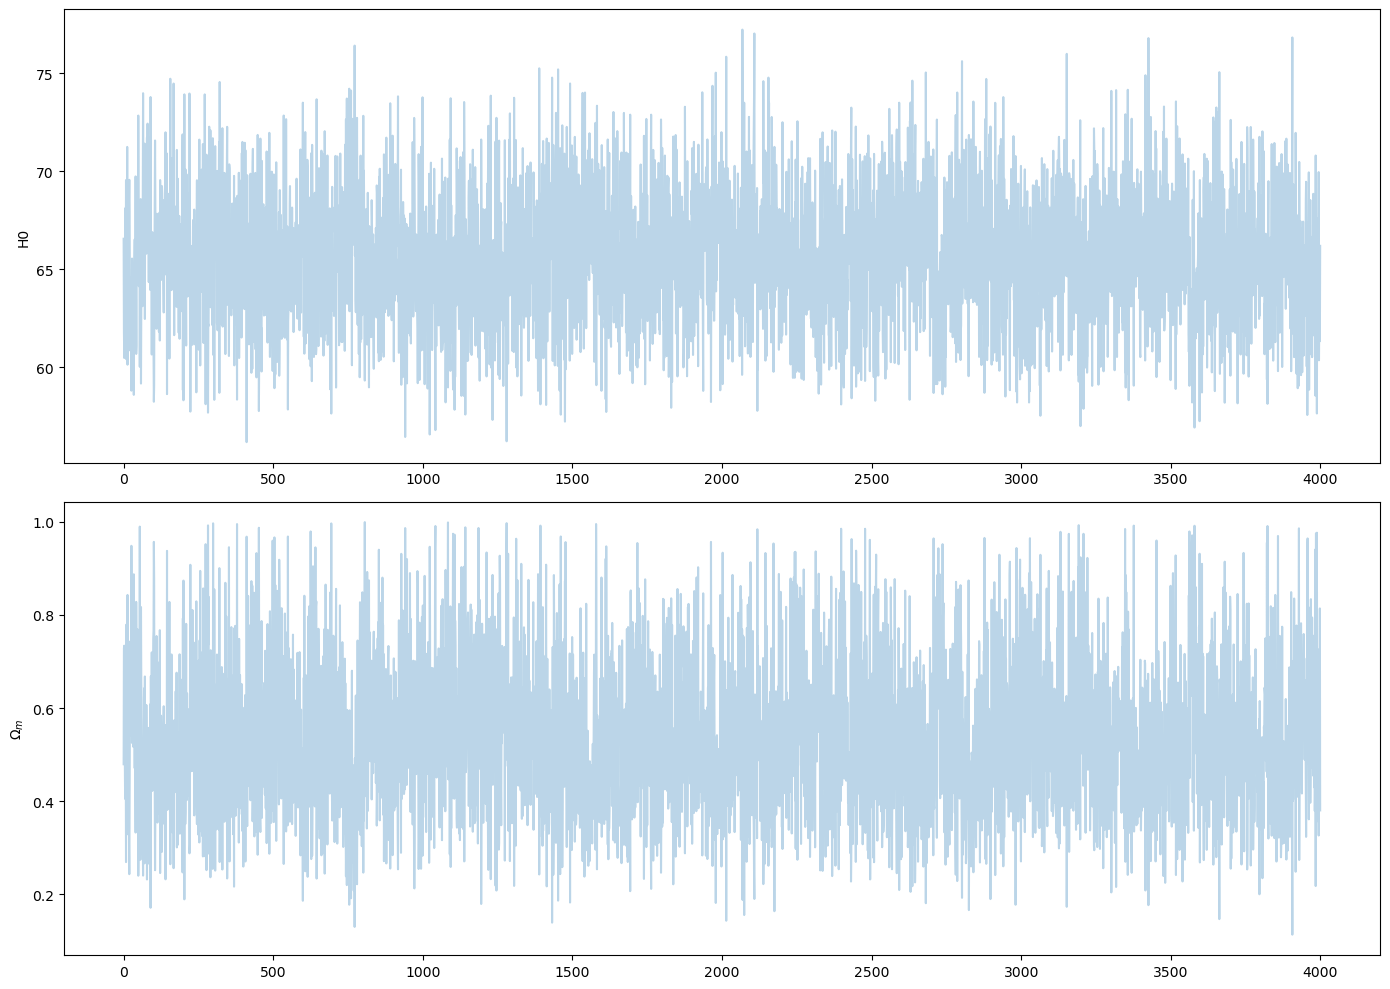

In [19]:
samples_h0_omegam = sampler_h0_omegam.get_chain(discard=burnin, thin=thin, flat=True)
print(f"Number of samples after burn-in and thinning: {len(samples_h0_omegam)}")
plot_chain_flattened(samples_h0_omegam, labels)

In [35]:
samples_h0 = samples_h0_omegam[:, 0]
samples_omegam = samples_h0_omegam[:, 1]

In [41]:
calculate_credible_region(samples_h0, 'H0')
calculate_credible_region(samples_omegam, 'Omega_m');

H0 = 65.649_{-5.661}^{+5.663}
Omega_m = 0.515_{-0.231}^{+0.334}


<>:1: SyntaxWarning: invalid escape sequence '\O'
<>:1: SyntaxWarning: invalid escape sequence '\O'
/var/folders/x5/_d4kcw01559cdbm8yn5mc8zm0000gn/T/ipykernel_14572/3766599713.py:1: SyntaxWarning: invalid escape sequence '\O'
  fig_h0_omegam = corner.corner(samples_h0_omegam, labels=["$H_0$", "$\Omega_m$"], quantiles=[0.16, 0.5, 0.84], show_titles=True)


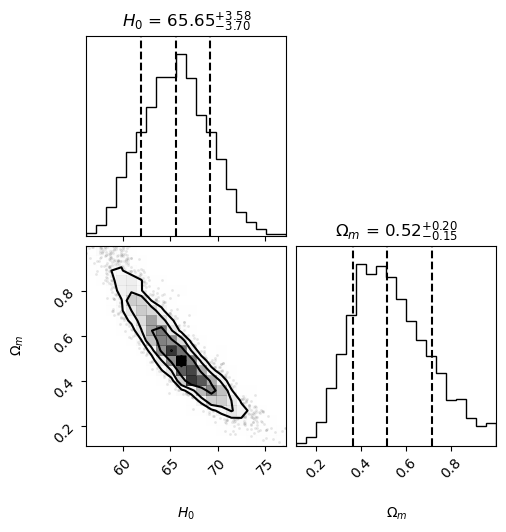

In [42]:
fig_h0_omegam = corner.corner(samples_h0_omegam, labels=["$H_0$", "$\Omega_m$"], quantiles=[0.16, 0.5, 0.84], show_titles=True)

Nested Sampling

In [78]:
def log_likelihood_h0_omegam_dynesty(theta, z, mu_obs, dmu_obs):
    H0, Omega_m = theta
    Omega_Lambda = 1.0 - Omega_m
    if not (0.0 <= Omega_m <= 1.0):
        return -np.inf
    mu_model = np.array([distance_modulus(zi, H0, Omega_m, Omega_Lambda) for zi in z])
    if not np.all(np.isfinite(mu_model)):
        return -np.inf
    chi2 = np.sum(((mu_obs - mu_model) / dmu_obs)**2)
    return -0.5 * chi2

# Prior transform function for the 2-parameter model
def prior_transform_h0_omegam(u):
    H0 = u[0] * (100.0 - 50.0) + 50.0  # H0 from 50 to 100
    Omega_m = u[1]  # Omega_m from 0 to 1
    return [H0, Omega_m]

In [79]:
ndim = 2
sampler_nested_h0_omegam = dynesty.NestedSampler(log_likelihood_h0_omegam_dynesty, prior_transform_h0_omegam, ndim,
                                            logl_args=(z_sample, mu_sample, dmu),
                                            bound='multi', sample='unif')

# Run the nested sampling
sampler_nested_h0_omegam.run_nested()

# Get the results
results_h0_omegam = sampler_nested_h0_omegam.results

2260it [02:03, 18.23it/s, +500 | bound: 2 | nc: 1 | ncall: 19552 | eff(%): 14.487 | loglstar:   -inf < -234.520 <    inf | logz: -238.196 +/-  0.073 | dlogz:  0.001 >  0.509]


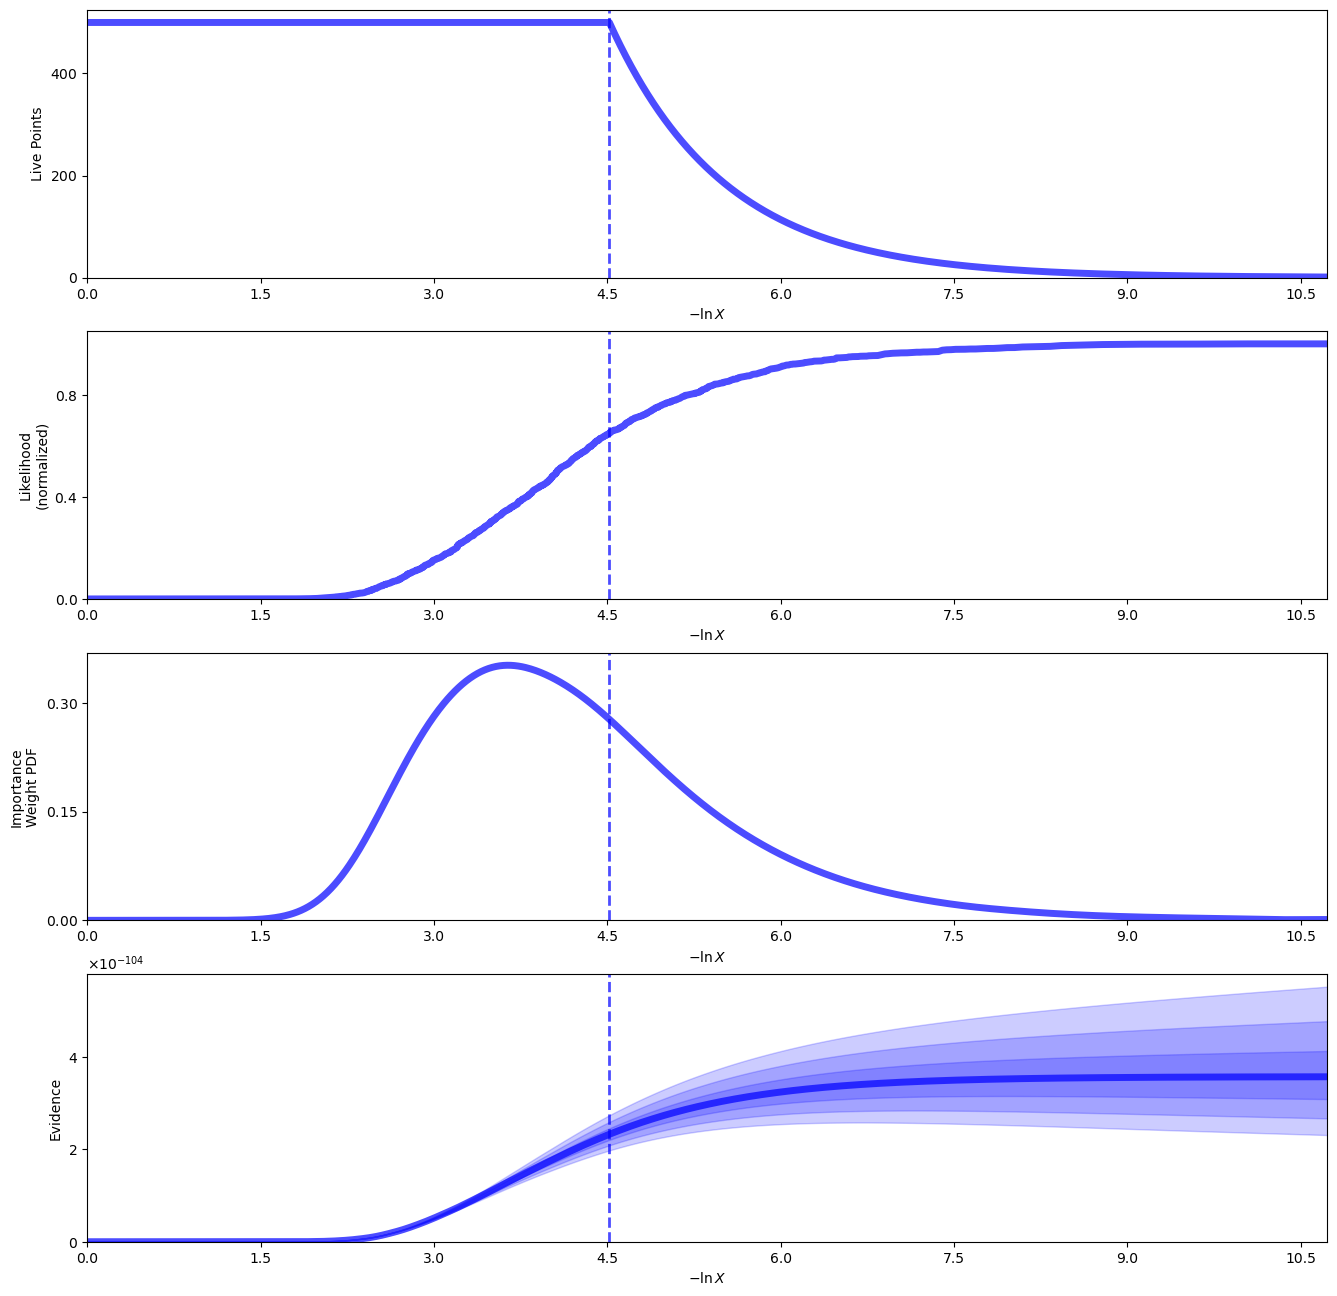

In [80]:
rfig, raxes = dyplot.runplot(results_h0_omegam)

In [81]:
samples_ns_h0_omegam = results_h0_omegam.samples
log_weights = results_h0_omegam.logwt
log_evidence_flat_2d = results_h0_omegam.logz[-1]
weights = np.exp(log_weights - log_evidence_flat_2d)

posterior_samples_h0_omegam = dyfunc.resample_equal(samples_ns_h0_omegam, weights)

In [34]:
print(f'H0 median: {np.median(posterior_samples_h0_omegam[:, 0])}')
print(f'Omega_m median: {np.median(posterior_samples_h0_omegam[:, 1])}')

H0 median: 65.67401042431807
Omega_m median: 0.5133818218629526


In [82]:
print(f'Log Evidence (H0 + Omega_m): {log_evidence_flat_2d}')

Log Evidence (H0 + Omega_m): -238.19564292840815


<>:1: SyntaxWarning: invalid escape sequence '\O'
<>:1: SyntaxWarning: invalid escape sequence '\O'
/var/folders/x5/_d4kcw01559cdbm8yn5mc8zm0000gn/T/ipykernel_14572/3337634536.py:1: SyntaxWarning: invalid escape sequence '\O'
  fig, axes = dyplot.cornerplot(results_h0_omegam, labels=["$H_0$", "$\Omega_m$"], show_titles=True, title_fmt=".2f")


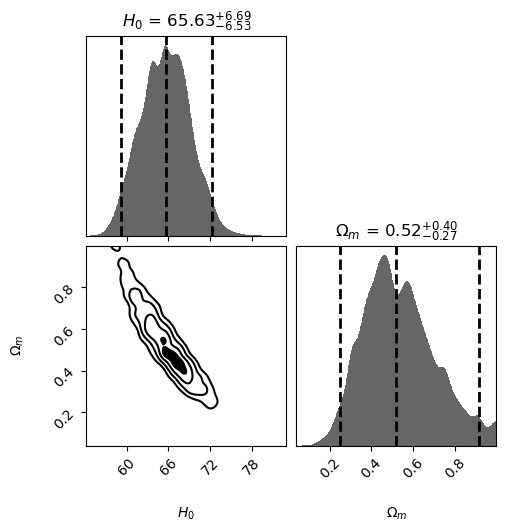

In [83]:
fig, axes = dyplot.cornerplot(results_h0_omegam, labels=["$H_0$", "$\Omega_m$"], show_titles=True, title_fmt=".2f")

It is possible to see that for the two parameter model MCMC and Nested Ssampling provide slightly different results. \
Moreover, data shows, as expected, that the uncertainty on H0 in the two parameter model estimation is higher with respect to the one in the estimation in the model which has it as its only parameter and that H0 and Omega_m are inegatively correlated, as can be seen from the joint distribution in the corner plots.

##STEP 4: Full 3D model

I will use Nested Sampling for this task in order to have the evidence which has to be used to compute the Bayes Factors.

I start by fitting the full model

In [ ]:
def log_likelihood_full_model(theta, z, mu_obs, dmu_obs):
    H0, Omega_m, Omega_Lambda = theta
    if Omega_m < 0 or Omega_Lambda < 0:
        return -np.inf # Non-negative density is a physical prior

    mu_model = np.array([distance_modulus(zi, H0, Omega_m, Omega_Lambda) for zi in z])
    if not np.all(np.isfinite(mu_model)):
        return -np.inf

    chi2 = np.sum(((mu_obs - mu_model) / dmu_obs)**2)
    return -0.5 * chi2

# Prior transform for the full 3D model
def prior_transform_full_model(u):
    H0 = u[0] * (100.0 - 50.0) + 50.0  # H0 from 50 to 100
    Omega_m = u[1]               # Omega_m from 0 to 1
    Omega_Lambda = u[2]      # Omega_Lambda from 0 to 1
    return [H0, Omega_m, Omega_Lambda]

In [112]:
ndim = 3
sampler_nested_full = dynesty.NestedSampler(log_likelihood_full_model, prior_transform_full_model, ndim,
                                            logl_args=(z_sample, mu_sample, dmu),
                                            bound='multi', sample='unif')
sampler_nested_full.run_nested()

2165it [02:01, 17.80it/s, +500 | bound: 3 | nc: 1 | ncall: 19134 | eff(%): 14.302 | loglstar:   -inf < -234.519 <    inf | logz: -238.013 +/-  0.069 | dlogz:  0.001 >  0.509]


In [113]:
results_full_model = sampler_nested_full.results
log_evidence_full = results_full_model.logz[-1]
print(f"Log Evidence for Full 3D Model: {log_evidence_full:.2f}")

Log Evidence for Full 3D Model: -238.01


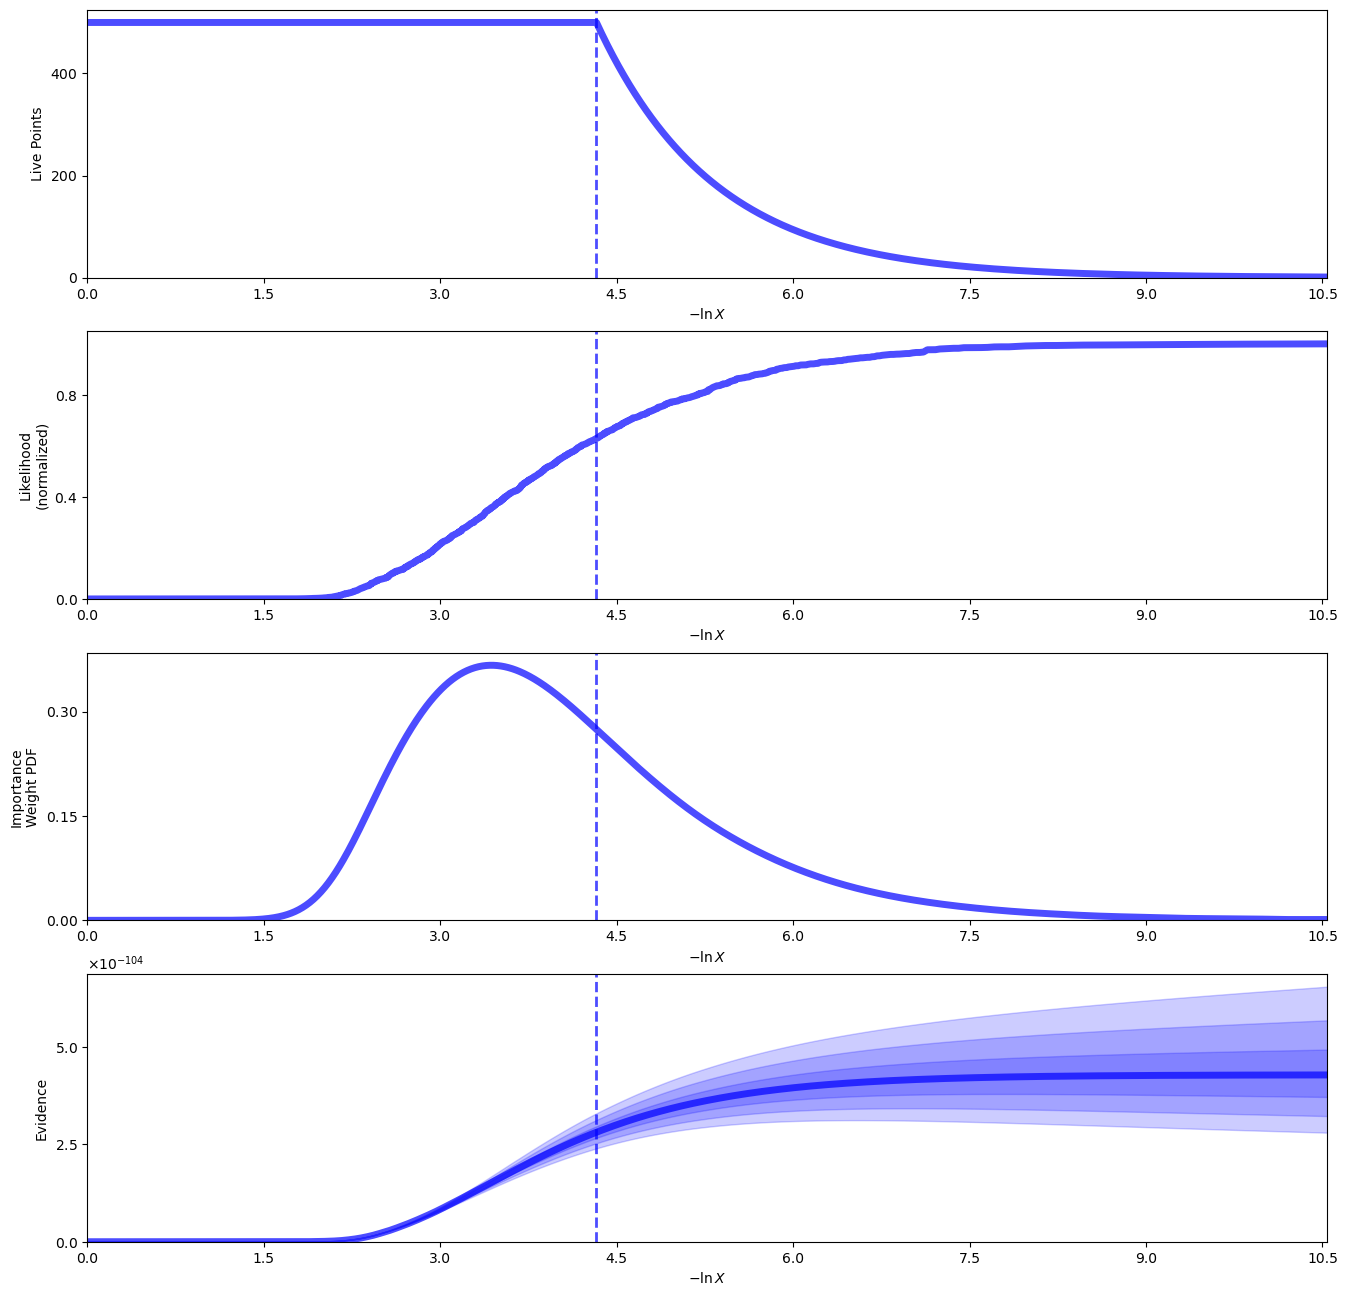

In [114]:
rfig, raxes = dyplot.runplot(results_full_model)

In [115]:
samples_ns_full = results_full_model.samples
log_weights = results_full_model.logwt
weights = np.exp(log_weights - log_evidence_full)

posterior_samples_full = dyfunc.resample_equal(samples_ns_full, weights)

In [116]:
print(f'H0 median: {np.median(posterior_samples_full[:, 0])}')
print(f'Omega_m median: {np.median(posterior_samples_full[:, 1])}')
print(f'Omega_Lambda median: {np.median(posterior_samples_full[:, 2])}')

H0 median: 72.69863634489495
Omega_m median: 0.4629639054745503
Omega_Lambda median: 0.32725390330002757


<>:1: SyntaxWarning: invalid escape sequence '\O'
<>:1: SyntaxWarning: invalid escape sequence '\O'
<>:1: SyntaxWarning: invalid escape sequence '\O'
<>:1: SyntaxWarning: invalid escape sequence '\O'
/var/folders/x5/_d4kcw01559cdbm8yn5mc8zm0000gn/T/ipykernel_14572/2084493071.py:1: SyntaxWarning: invalid escape sequence '\O'
  fig, axes = dyplot.cornerplot(results_full_model, labels=["$H_0$", "$\Omega_m$", "$\Omega_{\Lambda}$"], show_titles=True, title_fmt=".2f")
/var/folders/x5/_d4kcw01559cdbm8yn5mc8zm0000gn/T/ipykernel_14572/2084493071.py:1: SyntaxWarning: invalid escape sequence '\O'
  fig, axes = dyplot.cornerplot(results_full_model, labels=["$H_0$", "$\Omega_m$", "$\Omega_{\Lambda}$"], show_titles=True, title_fmt=".2f")


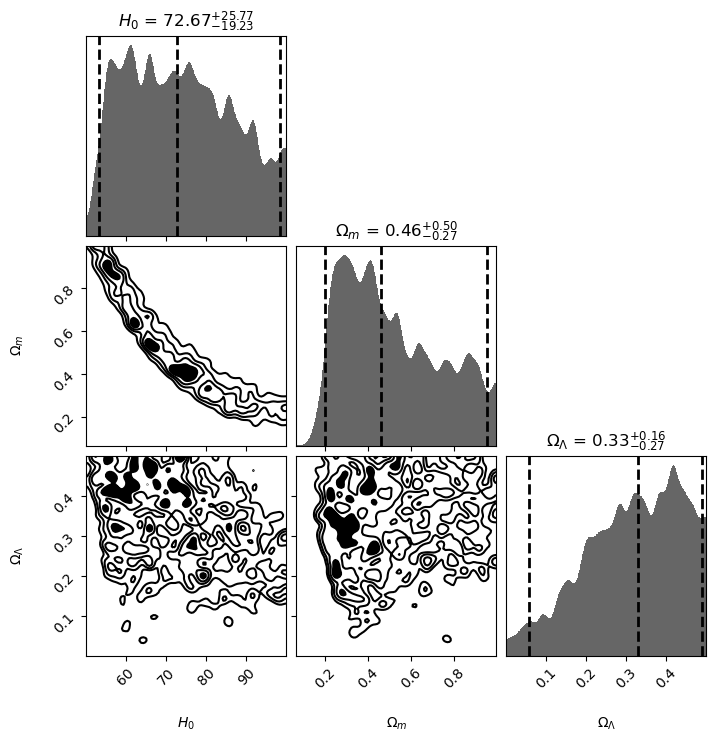

In [117]:
fig, axes = dyplot.cornerplot(results_full_model, labels=["$H_0$", "$\Omega_m$", "$\Omega_{\Lambda}$"], show_titles=True, title_fmt=".2f")

Bayes Factor computation

In [118]:
log_bayes_factor_flatness = log_evidence_flat_2d - log_evidence_full
bayes_factor_flatness = np.exp(log_bayes_factor_flatness)

print("--- Bayes Factor for Flatness (Omega_m + Omega_Lambda = 1) ---")
print(f"Log Bayes Factor: {log_bayes_factor_flatness:.2f}")
print(f"Bayes Factor: {bayes_factor_flatness:.2f}")

--- Bayes Factor for Flatness (Omega_m + Omega_Lambda = 1) ---
Log Bayes Factor: -0.18
Bayes Factor: 0.83


In [126]:
log_bayes_factor_dark_energy = log_evidence_full - log_evidence_h0_only
bayes_factor_dark_energy = np.exp(log_bayes_factor_dark_energy)

print("--- Bayes Factor for Dark Energy Existence ---")
print(f"Log Bayes Factor: {log_bayes_factor_dark_energy:.2f}")
print(f"Bayes Factor: {bayes_factor_dark_energy:.2f}")

--- Bayes Factor for Dark Energy Existence ---
Log Bayes Factor: 0.85
Bayes Factor: 2.34


##STEP 5: Data Cloning

I'll use the results from the full 3D model, since it is the one generally considered in the literature, for generating the cloned data.
Also, I use a Gaussian Kernel Density Estimator (KDE) to model the probability distribution of the original redshift sample (z_sample). This allows us to generate new redshifts that mimic the original mission's targeting strategy.

In [127]:
# 1. Estimate the PDF of z from the existing sample
kde_z = gaussian_kde(z_sample)

# 2. Generate 10 times more z values
num_cloned_data = len(z_sample) * 10
z_cloned = kde_z.resample(num_cloned_data)[0]

# Ensure z_cloned are positive and within a reasonable range
# Clipping prevents non-physical negative z values or extreme extrapolation
z_cloned = np.clip(z_cloned, 0.01, z_sample.max() * 1.5)

In [128]:
# Use the median best-fit parameters for the mock data
# Using illustrative numerical values consistent with the full 3D fit:
H0_mock = np.median(posterior_samples_full[:, 0])
Omegam_mock = np.median(posterior_samples_full[:, 1])
OmegaLambda_mock = np.median(posterior_samples_full[:, 2])

# Calculate the "true" mu values using the best-fit model
mu_cloned_true = np.array([distance_modulus(z, H0_mock, Omegam_mock, OmegaLambda_mock) for z in z_cloned])

# Estimate noise: The original dmu values range, so we use the median dmu as a representative noise floor.
# This assumes the new mission will have similar or slightly better noise characteristics.
median_dmu = np.median(dmu)
dmu_cloned = median_dmu * np.ones_like(mu_cloned_true) # Assign a constant uncertainty to the mock data

# Add Gaussian noise to the true mu values
mu_cloned = mu_cloned_true + dmu_cloned * np.random.randn(num_cloned_data)

# Combine the cloned data into a single array for output
cloned_sample = np.vstack([z_cloned, mu_cloned, dmu_cloned]).T

5000


<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
/var/folders/x5/_d4kcw01559cdbm8yn5mc8zm0000gn/T/ipykernel_14572/3794799591.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu$")


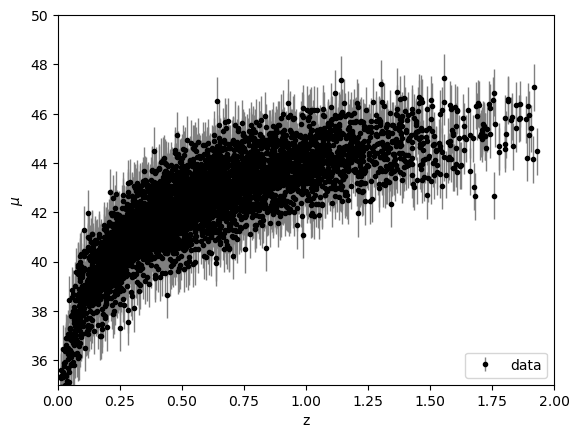

In [130]:
plt.errorbar(z_cloned, mu_cloned, dmu_cloned, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

print(len(z_cloned))

STEP 6: Alternative Methods \\
I will fit the 2 parameter flat model using the Levenberg-Marquardt algorithm (through its scipy.optimize.curve_fit implementation), in order to compare a frequentist approach to the previously used Bayesian methods

In [140]:
# Define the function for curve_fit: must take z as the first argument, followed by parameters
def mu_model_flat(z, H0, Omega_m):
    Omega_Lambda = 1.0 - Omega_m
    # curve_fit handles array inputs for z, so we apply distance_modulus element-wise
    return np.array([distance_modulus(zi, H0, Omega_m, Omega_Lambda) for zi in z])

# Initial guess and bounds
p0 = [70.0, 0.3]  # [H0, Omega_m]
bounds = ([50.0, 0.0], [100.0, 1.0]) # [H0_min, Om_min], [H0_max, Om_max]

# Perform the fit using Levenberg-Marquardt
# sigma=dmu weights the fit by the inverse of the error (1/dmu^2)
# absolute_sigma=True ensures sigma values are treated as absolute uncertainties
popt, pcov = scipy.optimize.curve_fit(mu_model_flat, z_sample, mu_sample, p0=p0, sigma=dmu, bounds=bounds, absolute_sigma=True)

<>:21: SyntaxWarning: invalid escape sequence '\O'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\L'
<>:21: SyntaxWarning: invalid escape sequence '\O'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\L'
/var/folders/x5/_d4kcw01559cdbm8yn5mc8zm0000gn/T/ipykernel_14572/3551543380.py:21: SyntaxWarning: invalid escape sequence '\O'
  plt.plot(z_sample, mu_best_fit, color='red', label=f'LM Best Fit (H0={H0_fit:.2f}, $\Omega_m$={Om_fit:.2f})')
/var/folders/x5/_d4kcw01559cdbm8yn5mc8zm0000gn/T/ipykernel_14572/3551543380.py:23: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("Distance Modulus ($\mu$)")
/var/folders/x5/_d4kcw01559cdbm8yn5mc8zm0000gn/T/ipykernel_14572/3551543380.py:24: SyntaxWarning: invalid escape sequence '\L'
  plt.title("Supernova Fit using Levenberg-Marquardt (Flat $\Lambda$CDM)")


--- Levenberg-Marquardt Results (Flat Model) ---
H0: 66.29 +/- 3.47 km/s/Mpc
Omega_m: 0.481 +/- 0.158
Minimum Chi-Squared (χ²): 469.04
Reduced Chi-Squared (χ²_red): 0.94


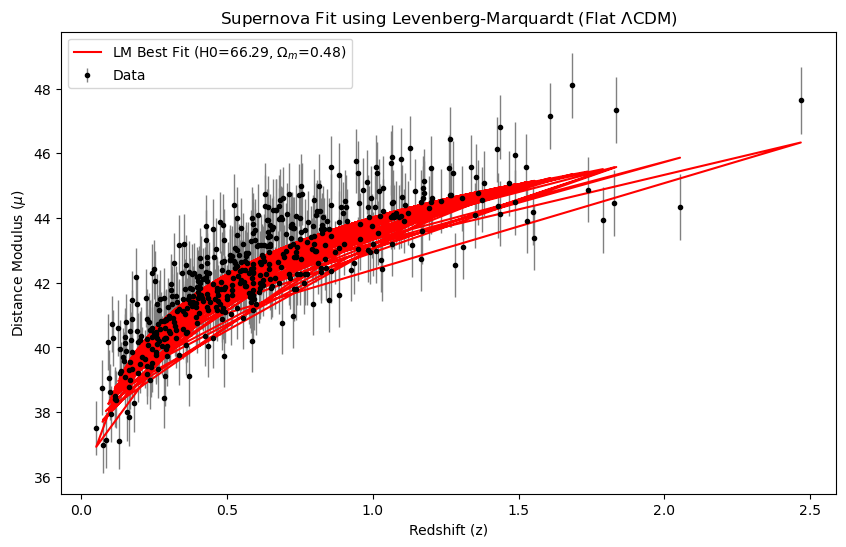

In [141]:
# Extract best-fit parameters and their 1-sigma uncertainties
H0_fit, Om_fit = popt
perr = np.sqrt(np.diag(pcov))
H0_err, Om_err = perr

# Calculate the minimum chi-squared and reduced chi-squared
mu_best_fit = mu_model_flat(z_sample, *popt)
chi2_min = np.sum(((mu_sample - mu_best_fit) / dmu)**2)
dof = len(z_sample) - len(popt) # Degrees of freedom: N_data - N_params
chi2_reduced = chi2_min / dof

print("--- Levenberg-Marquardt Results (Flat Model) ---")
print(f"H0: {H0_fit:.2f} +/- {H0_err:.2f} km/s/Mpc")
print(f"Omega_m: {Om_fit:.3f} +/- {Om_err:.3f}")
print(f"Minimum Chi-Squared (χ²): {chi2_min:.2f}")
print(f"Reduced Chi-Squared (χ²_red): {chi2_reduced:.2f}")

# Plot the result
plt.figure(figsize=(10, 6))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Data')
plt.plot(z_sample, mu_best_fit, color='red', label=f'LM Best Fit (H0={H0_fit:.2f}, $\Omega_m$={Om_fit:.2f})')
plt.xlabel("Redshift (z)")
plt.ylabel("Distance Modulus ($\mu$)")
plt.title("Supernova Fit using Levenberg-Marquardt (Flat $\Lambda$CDM)")
plt.legend()
plt.show()

The reduced chi square is close to 1, which means that the model might be a good fit. Also, the obtained values do not differ much from the values obtained through MCMC and Nested Sampling. 

While carrying an high computational cost, Bayesian methods, such as MCMC and Nested Sampling, provide the possibility of performing direct statistical inference on the parameters of the considered model. Moreover, they allow to incorporate prior knowledge in the estimation parameters, which can be both an advantage or a disadvantage, indeed choosing a good prior can lead to a better estimation of the model, a poor choice, though, can bias the results in a negative way. \\
Bayesian methods require tuning and diagnostics (such as burn-in and thinning) to ensure the samples are a true representation of the posterior but, on the other hand, they generate the full, multi-dimensional posterior distribution, also showing correlations between parameters and they also easly allow model comparison through the analysis of the Bayes factor, simplifying the process of model selection.